# Prediciting Inflation (and evaluating the Phillips Curve)

### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader
from scipy.optimize import curve_fit
import seaborn as sns
import datetime
import pandas_datareader as pdr
from scipy.integrate import simps
import statsmodels.formula.api as smf
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Downloading data


In [2]:
start = datetime.datetime(1978,1,1)
end = datetime.datetime(2023,3,30)

data = pdr.DataReader(['MICH', 'CPIAUCSL', 'UNRATE', 'NROUST', 'FEDFUNDS'], 'fred', start, end)

# Resample data to monthly frequency
data = data.resample('M').last()

# Fill missing values in NROUST column with last known observation
data['NROUST'] = data['NROUST'].fillna(method='ffill')

data['inflation_rate'] = data['CPIAUCSL'].pct_change(periods=12) * 100 # Yearly inflation rate
data['expected_inflation_lagged'] = data['MICH'].shift(12) #The expected inflation is a 12 month forward expectation.
#Creating lagged inflation:
data['lagged_inflation'] = data['inflation_rate'].shift(1)
data = data.drop('CPIAUCSL', axis = 1) # Dropping the old inflation measure
data = data.rename(columns={'UNRATE': 'unemploy_rate', 'NROUST': 'natural_rate_unemploy', 'MICH': 'expected_inflation'})

## Calculating the unemployment gap:
data['unemploy_gap'] = data['unemploy_rate'] - data['natural_rate_unemploy']

data.dropna(inplace = True) # Dropping NA values (first 12 months)
data.head(10)


,expected_inflation,unemploy_rate,natural_rate_unemploy,FEDFUNDS,inflation_rate,expected_inflation_lagged,lagged_inflation,unemploy_gap
DATE,,,,,,,,
1979-02-28,9.3,5.9,6.235909,10.06,9.841270,6.4,9.250399,-0.335909
1979-03-31,8.8,5.8,6.235909,10.09,10.252366,6.3,9.841270,-0.435909
1979-04-30,9.7,5.8,6.232617,10.01,10.485133,6.7,10.252366,-0.432617
1979-05-31,9.8,5.6,6.232617,10.24,10.697674,6.9,10.485133,-0.632617
1979-06-30,9.9,5.7,6.232617,10.29,11.076923,6.5,10.697674,-0.532617
1979-07-31,9.9,5.7,6.228394,10.47,11.450382,6.6,11.076923,-0.528394
1979-08-31,9.9,6.0,6.228394,10.94,11.836115,8.7,11.450382,-0.228394
1979-09-30,9.6,5.9,6.228394,11.43,11.879699,6.9,11.836115,-0.328394
1979-10-31,9.0,6.0,6.223290,13.77,12.071535,7.4,11.879699,-0.223290


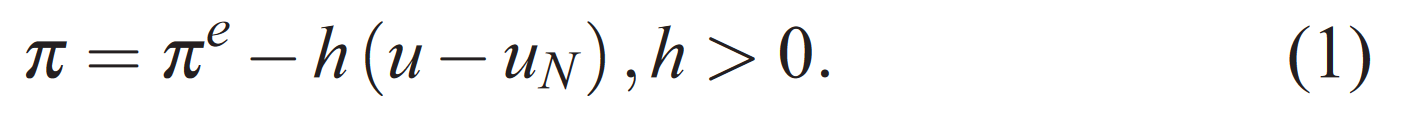

---

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

### Very Simple Philips Cruve
**Only inflation and unemployment rate.**

In [3]:
X = data['unemploy_rate']
y = data['inflation_rate']


<AxesSubplot:xlabel='unemploy_rate', ylabel='inflation_rate'>

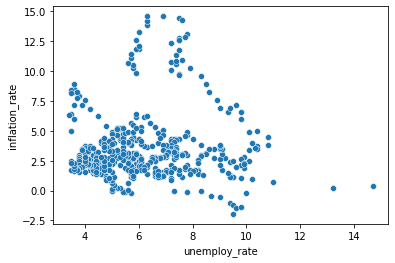

In [4]:
#Exploring
sns.scatterplot(x = X, y = y)

In [5]:
# Splitting the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [6]:
# Fitting the linear regression model
model = LinearRegression()
model.fit(X_train.values.reshape(-1,1), y_train)


LinearRegression()

In [7]:
y_pred = model.predict(X_test.values.reshape(-1,1))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 11.17910187798732
R2 Score: -0.03991120026701167


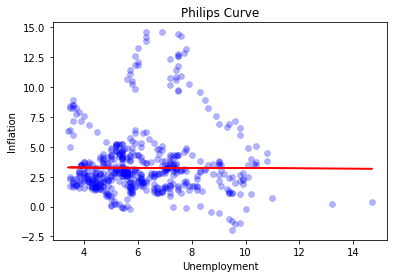

In [8]:
plt.scatter(X.values, y, color='blue', linewidths= 0.5, alpha = 0.3)
plt.plot(X.values, model.predict(X.values.reshape(-1,1)), color='red')
plt.xlabel('Unemployment')
plt.ylabel('Inflation')
plt.title('Philips Curve')
plt.show()



## Model Coefficent:


In [9]:
model.coef_

array([-0.00902919])

When unemployment increases with 1 percentage point, nothing really happens with inflation. 
The standard Phillips Curve seem not longer to be valid. 

# The model obviously not very good. We will try to solve the model for a more complex Philips Curve now.

### Expectations-augmented Phillips curve:

In [10]:
data

,expected_inflation,unemploy_rate,natural_rate_unemploy,FEDFUNDS,inflation_rate,expected_inflation_lagged,lagged_inflation,unemploy_gap
DATE,,,,,,,,
1979-02-28,9.3,5.9,6.235909,10.06,9.841270,6.4,9.250399,-0.335909
1979-03-31,8.8,5.8,6.235909,10.09,10.252366,6.3,9.841270,-0.435909
1979-04-30,9.7,5.8,6.232617,10.01,10.485133,6.7,10.252366,-0.432617
1979-05-31,9.8,5.6,6.232617,10.24,10.697674,6.9,10.485133,-0.632617
1979-06-30,9.9,5.7,6.232617,10.29,11.076923,6.5,10.697674,-0.532617
...,...,...,...,...,...,...,...,...
2022-11-30,4.9,3.6,4.431760,3.78,7.135348,4.9,7.762493,-0.831760
2022-12-31,4.4,3.5,4.431760,4.10,6.444940,4.8,7.135348,-0.931760
2023-01-31,3.9,3.4,4.428064,4.33,6.347156,4.9,6.444940,-1.028064


**We are calculating the difference between expected inflation and actual inflation. We calculate the difference, to simply the model solution. We are exploring the expected-augmented Phillips curve to explore the fixed coefficent on the unemployment gap.**

In [11]:
data['aug_inflation'] = data['inflation_rate'] - data['expected_inflation']

In [12]:
X = data['unemploy_gap'].values
y = data['aug_inflation'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [14]:
model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))


LinearRegression()

In [15]:
y_pred = model.predict(X_test.reshape(-1,1))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 2.773807680188617
R2 Score: 0.025704806893122822


In [16]:
model.coef_

array([[-0.195826]])

The model fits betters now. 

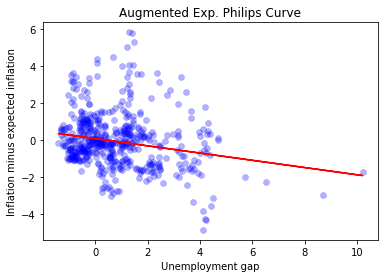

In [17]:
plt.scatter(X, y, color='blue', linewidths= 0.5, alpha = 0.3)
plt.plot(X, model.predict(X.reshape(-1,1)), color='red')
plt.xlabel('Unemployment gap')
plt.ylabel('Inflation minus expected inflation')
plt.title('Augmented Exp. Philips Curve')
plt.show()



The augmented Phillips Curve is way better. It fits more with the traditional theory. 

## Polynomial Augmented Exp. Phillips Curve

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [19]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train.reshape(-1,1))
X_test_poly = poly_features.transform(X_test.reshape(-1,1))


In [20]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [21]:
y_pred = model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 2.758779945725334
R2 Score: 0.030983272864443356


ValueError: x and y must be the same size

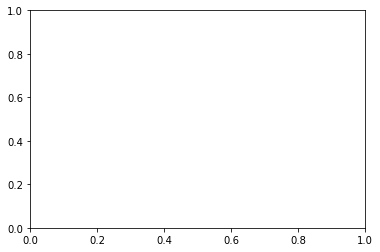

In [29]:
plt.scatter(X, y, color='blue')

X_plot = np.linspace(X.min(), X.max(), 100)
X_plot_poly = poly_features.transform(X_plot.reshape(-1, 1))
y_plot = model.predict(X_plot_poly)

plt.plot(X_plot, y_plot, color='red')
plt.xlabel('Unemployment Gap')
plt.ylabel('Inflation')
plt.title('Philips Curve (Polynomial Regression)')
plt.show()


The Polynomial Philips Curve takes a different shape because it trys to fit the extreme unemployment gap. 

# Gradient boosting

Our Data set

In [23]:
data

,expected_inflation,unemploy_rate,natural_rate_unemploy,FEDFUNDS,inflation_rate,expected_inflation_lagged,lagged_inflation,unemploy_gap,aug_inflation
DATE,,,,,,,,,
1979-02-28,9.3,5.9,6.235909,10.06,9.841270,6.4,9.250399,-0.335909,0.541270
1979-03-31,8.8,5.8,6.235909,10.09,10.252366,6.3,9.841270,-0.435909,1.452366
1979-04-30,9.7,5.8,6.232617,10.01,10.485133,6.7,10.252366,-0.432617,0.785133
1979-05-31,9.8,5.6,6.232617,10.24,10.697674,6.9,10.485133,-0.632617,0.897674
1979-06-30,9.9,5.7,6.232617,10.29,11.076923,6.5,10.697674,-0.532617,1.176923
...,...,...,...,...,...,...,...,...,...
2022-11-30,4.9,3.6,4.431760,3.78,7.135348,4.9,7.762493,-0.831760,2.235348
2022-12-31,4.4,3.5,4.431760,4.10,6.444940,4.8,7.135348,-0.931760,2.044940
2023-01-31,3.9,3.4,4.428064,4.33,6.347156,4.9,6.444940,-1.028064,2.447156


We will lagg all variables. We do this to be able to realisticaly predict the inflation rate. We want to use data from period t-1 to predict inflation rate in period t. Therefore, we will only use features that are lagged to predict future values of the inflation rate. (our data is monthly, so we shift 12 to shift a year) 

We use data today, to predict next years inflation

In [30]:
X = data.drop('lagged_inflation', axis = 1).shift(12)
X = X.dropna()
y = data['inflation_rate']
y = y[X.index]

The above can be interpreted from a log-log model, where the coefficient for the unemployment gap is 0.03, which means that when the unemployment gap increases by 1 percentage point, the inflation gap will increase by 3 percentage points. The coefficient for the interest rate means that when the interest rate increases by 1 percentage point, the inflation gap will increase by 24 percentage points. 

Making sure the inflation rate in X is not the same as in y. (Remember, we use lagged inflation in X. We will rename it for convenience. 

In [31]:
X['inflation_rate'][0] != y[0]

True

In [32]:
X.rename(columns={'inflation_rate': 'lag_inflation'}, inplace=True)


We will also drop the unemployment rate, the natural rate of unemployment and the aug_inflation. The unemployment rate and natural rate is already included as unemploy gap. Aug_inflation is also a combination of different features. We will just drop it for convenience. 

In [33]:
X = X.drop(["natural_rate_unemploy", 'aug_inflation', 'unemploy_rate', 'expected_inflation_lagged'], axis = 1)

We will conduct a grid search to fine tune our model. 

In [36]:
param_grid = {
    'learning_rate': [0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
}
gbc = GradientBoostingRegressor(n_estimators=100)

We will use a k-fold split. This ensures our results are not dependent on the initial split. Our data set is not the largest, and therefore, we deem it preferable to use a k-fold split. 

We will also have a hold-out set, which we will evaluate our model on. 

In [37]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42) # 10-fold cross-validation
grid_search = GridSearchCV(gbc, param_grid, cv=kfold, scoring='neg_mean_squared_error')


We initialize the model (note: if it takes forever. Adjust the n_estimators, and/or the param_grid)

In [39]:
grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.2, 0.1, 0.05, 0.02, 0.01, 0.005]},
             scoring='neg_mean_squared_error')

The results from our model

In [40]:
y_pred = grid_search.best_estimator_.predict(X_test)


#  Evaluation metrics on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test set evaluation:')
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2: ', r2)

Test set evaluation:
MSE:  1.860268358450487
RMSE:  1.3639165511315152
MAE:  0.8566664324096837
R2:  0.8073230013620817


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Lets compare the model, with a really naive one. We will try to predict the inflation from only lagged inflation. Lets see, if the results match the advanced algoritm from our gradient boosting model.

In [42]:
y

DATE
1980-02-29    14.161850
1980-03-31    14.592275
1980-04-30    14.589235
1980-05-31    14.425770
1980-06-30    14.265928
                ...    
2022-11-30     7.135348
2022-12-31     6.444940
2023-01-31     6.347156
2023-02-28     5.986438
2023-03-31     4.986920
Freq: M, Name: inflation_rate, Length: 518, dtype: float64

In [43]:
y_lagged = y.shift(12)
y_lagged = y_lagged.dropna()

y_new = y[y_lagged.index]

# Split the lagged target variable into a train+validation set and a test set
y_train_val, y_test, y_lagged_train_val, y_lagged_test = train_test_split(y_new, y_lagged, test_size=0.2, random_state= 42, shuffle=False)# Use the lagged target variable as the
# Reshape the data to the format expected by scikit-learn
y_lagged_train_val_reshaped = y_lagged_train_val.values.reshape(-1, 1)
y_lagged_test_reshaped = y_lagged_test.values.reshape(-1, 1)

# Create and fit the linear regression model
lr = LinearRegression()
lr.fit(y_lagged_train_val_reshaped, y_train_val)

# Make predictions on the test set
y_pred_lr = lr.predict(y_lagged_test_reshaped)

# Compute the evaluation metrics for the linear regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print('Linear regression model test set evaluation:')
print('MSE: ', mse_lr)
print('RMSE: ', rmse_lr)
print('MAE: ', mae_lr)
print('R2: ', r2_lr)

Linear regression model test set evaluation:
MSE:  4.539329095386475
RMSE:  2.1305701338811813
MAE:  1.5001157098150537
R2:  0.2506083291654455


## Wrap up (CONCLUSION)

Based on the evaluation metrics, our Gradient Boosting model has clearly outperformed the simple linear regression model in predicting the inflation rate.

The MSE, RMSE, and MAE are all lower for the Gradient Boosting model, indicating that its predictions are, on average, closer to the true values. Moreover, the R2 score, which explains the proportion of the variance in the dependent variable that is predictable from the independent variable(s), is much higher for the Gradient Boosting model, indicating that it explains more of the variance in your data.

However, while it's tempting to conclude that the Gradient Boosting model is superior based on these results, there are a few important considerations to keep in mind:

    Overfitting: Gradient Boosting, being a more complex model, is more prone to overfitting compared to a simple linear regression model. Although we've taken care to validate our model using k-fold cross-validation, it's still possible that the model may not generalize well to new data. It is always recommended to test the model on new, unseen data to ensure its robustness.

    Interpretability: The Gradient Boosting model, like many machine learning models, is less interpretable than a simple linear regression model. While the linear regression model allows us to directly interpret the relationship between the predictors and the target variable, interpreting a Gradient Boosting model is much more complex and often requires additional tools or methods.

    Computational Complexity: Gradient Boosting models are more computationally intensive than linear regression models. This may not be a problem with our current dataset, but for larger datasets, training and prediction times could become an issue.

    Robustness to Changes: Machine learning models, including Gradient Boosting, often rely on the underlying distribution of the data remaining stable over time. If the process generating our data changes, the model may become less accurate. On the other hand, simpler models like linear regression can sometimes be more robust to such changes.

In conclusion, while our Gradient Boosting model has shown superior performance on our current dataset, it's important to consider these factors before deciding on the final model. One should continue monitoring the performance of the model on new data, and consider other aspects such as interpretability and computational complexity in addition to predictive accuracy.

## Additionally (Scipy)


### scipy.optimize.minimize

In [44]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective(params, X, y):
    a, b = params
    y_pred = a + b * X
    return np.sum((y - y_pred)**2)

# Set the initial guess for the parameters
initial_guess = [0, 0]

# Extract the relevant variables from your data
X = data['unemploy_gap'].values
y = data['aug_inflation'].values

# Minimize the objective function
result = minimize(objective, initial_guess, args=(X, y))

# Extract the optimal parameter values
a_optimal, b_optimal = result.x

# Print the results
print(f"Optimal a: {a_optimal}")
print(f"Optimal b: {b_optimal}")


Optimal a: 0.16382885630379992
Optimal b: -0.21011015730789573


That means, when the unemployment gap increases with one 1 percentage point, our aug_inflation decreases with 0,21 percentage point. Remember, the aug_inflation is the difference between actual inflation and expected inflation